In [1]:
import os, sys, time, resource, re, gc, shutil
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

run_id = 665

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


In [2]:
tsums = topics.aggregate(
    ip_score=Sum('ipcc_score'),
    score=Sum('ipcc_time_score')
)
tsums

topics.update(
    ipcc_share=F('ipcc_score')/tsums['ip_score'],
    share=F('ipcc_time_score')/tsums['score']
)

100

In [3]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]


In [4]:



df = pd.DataFrame.from_dict(
    list(topics.values(
        'title',
        'score',
        'ipcc_coverage',
        'share',
        'ipcc_score',
        'ipcc_share',
        'ipcc_time_score',
        'primary_wg'
    ))
)

df, df_disp  = calculate_deviations(df)


df.sort_values('representation').head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation
5,0.025469,6.915498,0.001387,271.524705,3,986.638731,0.008715,"{adsorpt, captur, process}",-0.007327,0.007327,0.159197
32,0.042169,16.713344,0.003353,396.346373,2,773.697814,0.012721,"{sediment, deposit, eros}",-0.009368,0.009368,0.263578
15,0.047201,7.924519,0.001590,167.889351,3,408.596166,0.005389,"{soc, stock, organ}",-0.003799,0.003799,0.295033
71,0.047744,9.963775,0.001999,208.690670,1,430.896811,0.006698,"{cal, pollen, holocen}",-0.004699,0.004699,0.298430
20,0.052494,17.853287,0.003582,340.098280,1,699.018737,0.010916,"{delta, isotop, thousand}",-0.007334,0.007334,0.328122


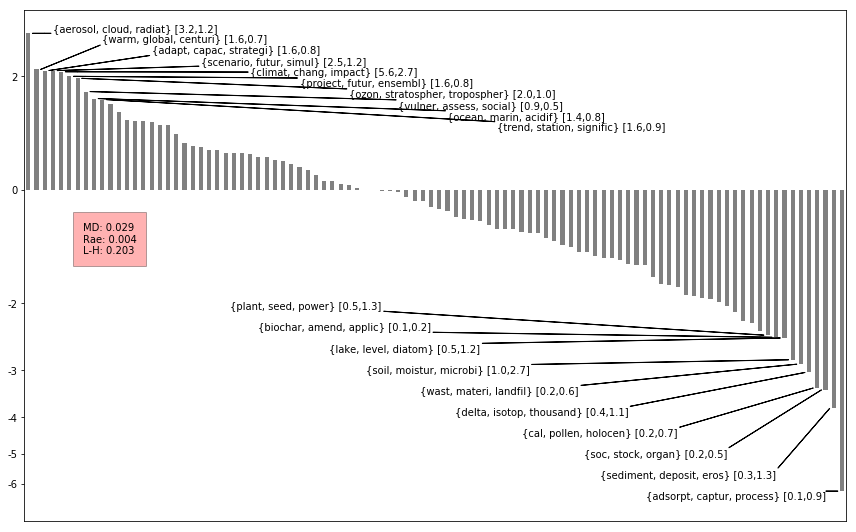

In [5]:

from matplotlib import ticker


plt.rcParams["figure.figsize"] = [12,7.5]

def plot_representation(df, ax, nts=5, xspace=3,yspace = 0.15, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index()#.set_index('title')

    pdf = pdf[pdf['share'] > 0.001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax,color="grey")

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=((xspace-3)*-1+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xspace-3-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=10,xspace=6,yspace=0.07)
plt.tight_layout()
plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.png'.format(run_id),bbox_inches='tight')
plt.show()

In [6]:
rmin = -1.5
rmax = 1
lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)

ytick_labels = [i for i in range(lmin,lmax) if i not in [-1,1]]
print(ytick_labels)
yticks = []
for x in ytick_labels:
    if x < 0:
        x = np.log(-1/x)
    elif x==0:
        x = 0
    else:
        x = np.log(x)
    yticks.append(x)
#yticks = [np.log(x) if x!=0 else 0 for x in ytick_labels ]
print(yticks)

[-4, -3, -2, 0]
[-1.3862943611198906, -1.0986122886681098, -0.6931471805599453, 0]


plt.rcParams["figure.figsize"] = [16,12]

stat = RunStats.objects.get(pk=run_id)

fig = plt.figure()


disp = pd.DataFrame(columns=['AR','MD','Rae','L-H'])
#fig, axs = plt.subplots(2,3,sharey=True)

for i, tp in enumerate(stat.periods.filter(n__lt=6)):
    if i == 0:
        ax = fig.add_subplot(2,3,i+1)
        ax1 = ax
    else:
        ax = fig.add_subplot(2,3,i+1,sharey=ax1)
    print(tp)
    tdts = TimeDTopic.objects.filter(dtopic__run_id=run_id,period=tp)
    
    df = pd.DataFrame.from_dict(
        list(tdts.values(
            'dtopic__title',
            'score',
            'share',
            'ipcc_score',
            'ipcc_share',
            #'ipcc_time_score'
        ))
    )
    
    df = df.rename(columns={'dtopic__title':'title'})
    
    df, df_disp  = calculate_deviations(df)
    df_disp['AR'] = tp.title   
    disp = disp.append(pd.DataFrame.from_dict([df_disp]))

    plot_representation(df, ax, 2.3,1)
    
    ax.set_title(tp.title)
    
    if tp.title=="AR5":
        ax = fig.add_subplot(2,3,6)
        
        disp = disp.set_index('AR')
        
        disp.plot(ax=ax)
        
        ax.set_title("Disproportionality")
    
    
    
    #plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_{}.png'.format(run_id,tp.title),bbox_inches='tight')
    #plt.show()

plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_ARS.png'.format(run_id),bbox_inches='tight')
plt.show()

disp.head()

In [7]:
tds = topics.filter(timedtopic__period__n__lt=6).values(
    'title','timedtopic__period__title','timedtopic__period__n','timedtopic__score','score'
).order_by('id','timedtopic__period__n')

tdf = pd.DataFrame.from_dict(list(tds))

#tdf['ys'] = tdf[]

tdf['share'] = tdf['timedtopic__score'] / tdf['score']

tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']


tdf.head(12)
#tdf.groupby('')

,score,timedtopic__period__n,timedtopic__period__title,timedtopic__score,title,share,ys
0,702.516289,1,AR1,0.056189,"{thermal, toler, stress}",0.000080,0.000080
1,702.516289,2,AR2,5.653864,"{thermal, toler, stress}",0.008048,0.016096
2,702.516289,3,AR3,15.483833,"{thermal, toler, stress}",0.022041,0.066122
3,702.516289,4,AR4,49.657870,"{thermal, toler, stress}",0.070686,0.282743
4,702.516289,5,AR5,186.650982,"{thermal, toler, stress}",0.265689,1.328446
5,416.915870,1,AR1,0.658598,"{rice, paddi, straw}",0.001580,0.001580
6,416.915870,2,AR2,14.927180,"{rice, paddi, straw}",0.035804,0.071608
7,416.915870,3,AR3,43.084759,"{rice, paddi, straw}",0.103342,0.310025
8,416.915870,4,AR4,63.927854,"{rice, paddi, straw}",0.153335,0.613341
9,416.915870,5,AR5,121.298793,"{rice, paddi, straw}",0.290943,1.454715


In [8]:
means = tdf.groupby('title')['ys'].mean()

means = pd.DataFrame({'ys' : tdf.groupby('title')['ys'].mean()}).reset_index()

mdf = df.merge(means)

mdf.head()

means.sort_values('ys',ascending=False).head()



,title,ys
53,"{ozon, stratospher, tropospher}",0.631604
98,"{year, period, annual}",0.621739
3,"{atmospher, surfac, observ}",0.604195
63,"{record, dure, glacial}",0.601979
78,"{solar, radiat, irradi}",0.589807


In [9]:
for name, group in tdf.groupby('title'):
    l = []
    for index, y in group.iterrows():
        print(y.share)
        l = l + [y.timedtopic__period__n] * round(y.share*100)
        
    print(l)
    
    print(np.mean(l))
    
    mdf.loc[mdf['title']==name]['av_year'] = np.mean(l)
    
    break

5.779062911979297e-06
0.005276669105451283
0.02950747017030758
0.08765205152425058
0.37479632151992137
[2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
4.64


/home/galm/software/django/tmvenv/lib/python3.4/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [10]:
def year_av(x):
    group = tdf[tdf['title']==x['title']]
    l = []
    for index, y in group.iterrows():
        l = l + [y.timedtopic__period__n] * round(y.share*100)
    return np.mean(l)

mdf['year_av'] = df.apply(year_av,axis=1)

mdf.head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av
0,0.195676,104.124585,0.020889,532.127627,1,1369.474725,0.017079,"{temperatur, air, mean}",0.003810,0.003810,1.223091,0.523686,4.350000
1,0.199567,30.255543,0.006070,151.605890,2,486.554480,0.004866,"{urban, citi, area}",0.001204,0.001204,1.247413,0.410050,4.857143
2,0.117054,62.139951,0.012466,530.866630,1,1103.288027,0.017039,"{record, dure, glacial}",-0.004572,0.004572,0.731656,0.601979,4.300000
3,0.318991,82.049190,0.016461,257.214428,2,711.368354,0.008255,"{project, futur, ensembl}",0.008205,0.008205,1.993886,0.501249,4.660377
4,0.109579,39.609601,0.007946,361.469746,3,882.659217,0.011602,"{gas, greenhous, hydrat}",-0.003655,0.003655,0.684936,0.484889,4.263158


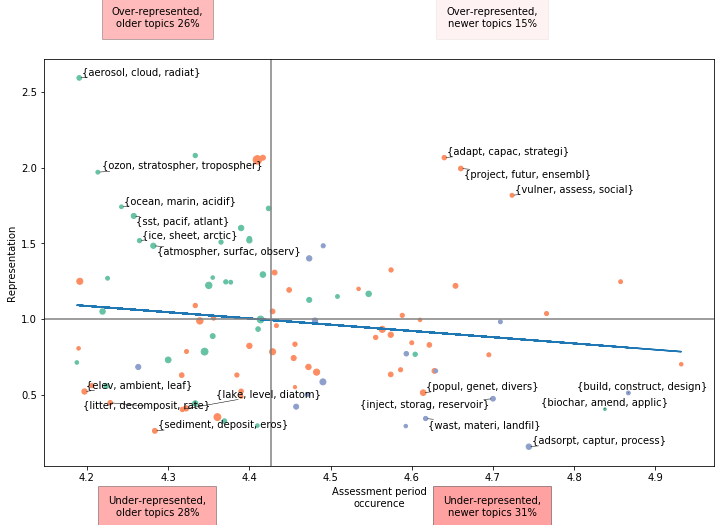

In [11]:
x = 'year_av'
y = 'representation'

fig, ax = plt.subplots()

cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
colors = [cmap[i] for i in mdf['primary_wg']]


mdf.plot.scatter(
    x,y,s=mdf['score']*0.03,
    c = colors,ax=ax
)

z = np.polyfit(x=mdf[x], y=mdf[y], deg=1)
p = np.poly1d(z)
mdf['trendline'] = p(mdf.loc[:, x])

plt.plot(mdf[x],mdf['trendline'])

qs = 5

mdf['x_q'] = pd.qcut(mdf[x], qs, labels=False)
mdf['y_q'] = pd.qcut(mdf[y], qs, labels=False)
texts = []


#for i, x in mdf[mdf['year_av']> 5.42].iterrows():
for i, row in mdf[(mdf['x_q'].isin([0,qs-1])) & (mdf['y_q'].isin([0,qs-1]))].iterrows():
    texts.append(plt.text(row[x],row[y],row['title'],ha='center', va='center'))
    
adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.axhline(1,c="grey")
plt.axvline(mdf[x].median(),c="grey")



# Put labels on the quadrants
# x
d1 = mdf[x].median()-plt.xlim()[0]
d2 = mdf[x].median()-plt.xlim()[1]

xlabpoints = [mdf[x].median()-d1/2,mdf[x].median()-d2/2]
labels = [
    ['Under-represented,\nolder topics','Under-represented,\nnewer topics'],
    ['Over-represented,\nolder topics','Over-represented,\nnewer topics']
]

pylims = plt.ylim()

tpad = (pylims[1]-pylims[0])*0.1




ops = [operator.lt,operator.gt]


for i in [0,1]:
    for j in [0,1]:
        if j==0:
            tpadx=tpad*-1
        else:
            tpadx=tpad
            
        q = mdf[(ops[i](mdf[x],mdf[x].median())) & (ops[j](mdf[y],1))]
        qshare = q['score'].sum()/mdf['score'].sum()
        plt.text(
            xlabpoints[i],
            pylims[j]+tpadx,
            labels[j][i] + " {:.0%}".format(qshare),
            va="center",ha="center",
            bbox={'facecolor':'red', 'alpha':qshare*2-0.25, 'pad':10}
        )

        

#ax.get_yaxis().set_visible(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
#ax2.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Assessment period\noccurence')
plt.ylabel('Representation')



plt.show()

In [12]:
np.polyfit(x=mdf[x], y=mdf[y], deg=1)

array([-0.41194282,  2.81742958])

In [13]:
mdf.sort_values('x_q').head(15)

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av,trendline,x_q,y_q
32,0.042169,16.713344,0.003353,396.346373,2,773.697814,0.012721,"{sediment, deposit, eros}",-0.009368,0.009368,0.263578,0.572748,4.283582,1.052839,0,0
82,0.168143,78.994789,0.015848,469.808260,1,992.841626,0.015079,"{year, period, annual}",0.000769,0.000769,1.050991,0.621739,4.219178,1.079369,0,3
63,0.414534,158.438376,0.031786,382.208283,1,715.965406,0.012267,"{aerosol, cloud, radiat}",0.019518,0.019518,2.591085,0.527287,4.190476,1.091193,0,4
78,0.237438,99.749562,0.020012,420.108690,1,907.196136,0.013484,"{atmospher, surfac, observ}",0.006528,0.006528,1.484126,0.604195,4.281690,1.053618,0,4
85,0.089902,28.023962,0.005622,311.716319,2,607.755372,0.010005,"{site, permafrost, peat}",-0.004383,0.004383,0.561942,0.582123,4.205882,1.084847,0,1
37,0.268922,123.907409,0.024858,460.755760,1,867.563139,0.014788,"{sst, pacif, atlant}",0.010070,0.010070,1.680923,0.568265,4.257576,1.063552,0,4
19,0.203183,52.245728,0.010481,257.136715,1,487.872139,0.008253,"{solar, radiat, irradi}",0.002228,0.002228,1.270012,0.589807,4.225352,1.076826,0,3
39,0.129208,23.735961,0.004762,183.704200,2,416.915870,0.005896,"{rice, paddi, straw}",-0.001134,0.001134,0.807624,0.490254,4.189655,1.091531,0,2
76,0.089491,33.583084,0.006737,375.266763,1,770.026746,0.012044,"{flux, measur, net}",-0.005307,0.005307,0.559373,0.567727,4.223881,1.077432,0,1
48,0.315085,98.137448,0.019688,311.463060,1,491.453417,0.009997,"{ozon, stratospher, tropospher}",0.009691,0.009691,1.969471,0.631604,4.213333,1.081777,0,4


In [14]:
mdf[mdf[y].isna()]

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av,trendline,x_q,y_q
